## Chaper 2: Search problems

### 2.1 Linear and binary search

Comparison of simple search algorithms on an iterable data structure (e.g. list, set).

In [90]:
from timeit import timeit


def native_set_contains(iterable, key):
    return key in set(iterable)

def native_list_contains(iterable, key):
    return key in iterable

def linear_contains(iterable, key):
    for item in iterable:
        if item == key:
            return True
    return False

def binary_contains(iterable, key):
    # iterable must be sorted
    low = 0
    high = len(iterable) - 1
    while low <= high:
        mid = (low + high) // 2
        if key > iterable[mid]:
            low = mid + 1
        elif key < iterable[mid]:
            high = mid - 1
        else:  # key is exactly at the midpoint
            return True
    return False
        

By the graphical comparison below, you can tell the following:

1. Although Python sets can search in O(1) time (flat curve), performance is overall slower because of the overhead of creating and maintaining the set (computing hash functions, etc.). There seems to be a peak in timing for values around the midpoint, why might that be? (Note that sets are unordered.)
2. Python's built-in _in_ operator is twice as fast as a simple linear search with for-loop. They must have some optimization going on under the hood.
3. However, for both linear search methods performance is strongly dependent on the chosen key. Specifically, there is a linear effect of order (key index): keys that appear earlier in the list are faster to find. For keys that are not present in the list, linear search is equally slow regarless of key.
4. Only binary search has a flat curve. Relatively speaking, the key's index has no effect of resulting search time. An advantage is seen for keys that are 1/2^n.

Note that timings are for repeated executions, so absolute values are meaningless. We only care about relative differences between algorithms and between chosen keys within an algorithm.

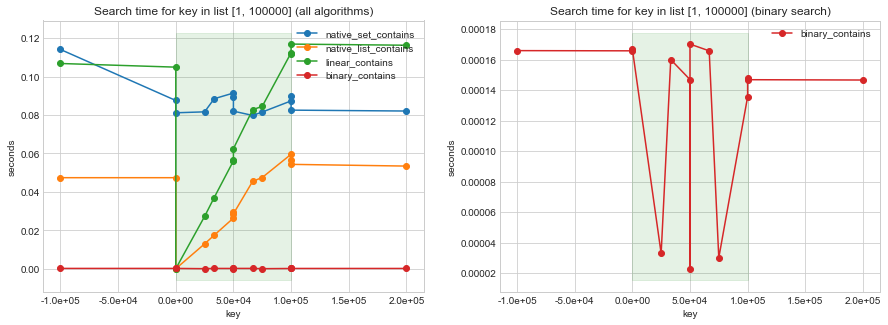

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,5))

n = int(1e5)
x = [i for i in range(1, n+1)]
keys = [-n, 0, 1, n//4, n//3, n//2-1, n//2, n//2+1, 2*n//3, 3*n//4, n-1, n, n+1, 2*n]

y_nativeset = [timeit(lambda: native_set_contains(x, k), number=50) for k in keys]
y_nativelist = [timeit(lambda: native_list_contains(x, k), number=50) for k in keys]
y_linear = [timeit(lambda: linear_contains(x, k), number=50) for k in keys]
y_binary = [timeit(lambda: binary_contains(x, k), number=50) for k in keys]

# All algorithms
ax1 = plt.subplot(121)
plt.plot(keys, y_nativeset, 'o-', label='native_set_contains')
plt.plot(keys, y_nativelist, 'o-', label='native_list_contains')
plt.plot(keys, y_linear, 'o-', label='linear_contains')
plt.plot(keys, y_binary, 'o-', label='binary_contains')
    
ax1.get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax1.set(xlabel='key', ylabel='seconds',
       title=f'Search time for key in list [{x[0]}, {x[-1]}] (all algorithms)')
plt.legend();

# Add shaded regions for keys that are actually contained in list
plt.fill_betweenx(ax1.get_ylim(), x[0], x[-1], color = 'g', alpha = 0.1);

# Zoom-in into binary search
ax2 = plt.subplot(122)
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
plt.plot(keys, y_binary, 'o-', color=color, label='binary_contains')
    
ax2.get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax2.set(xlabel='key', ylabel='seconds',
       title=f'Search time for key in list [{x[0]}, {x[-1]}] (binary search)')
plt.legend();

# Add shaded regions for keys that are actually contained in list
plt.fill_betweenx(ax2.get_ylim(), x[0], x[-1], color = 'g', alpha = 0.1);


### 2.2 Maze solving

Let's create the generic data structures on which our search algorithms will operate. These will apply with some distinctions to multiple search problems in the book (mazes, Missionaries and Cannibals problem).

In [3]:
from abc import ABC, abstractmethod

class SearchProblem(ABC):
    # Abstract base class for all search problems
    # Note: 'A class that is derived from an abstract class cannot be
    # instantiated unless all of its abstract methods are overridden.'
    
    @abstractmethod
    def goal_test(self, *args, **kwargs):
        pass
    
    @abstractmethod
    def successors(self, *args, **kwargs):
        pass

Now let's focus on the Maze solving problem.

In [4]:
from enum import Enum
from typing import NamedTuple
import random


class Cell(str, Enum):
    EMPTY = " "
    BLOCKED = "■"
    START = "S"
    GOAL = "G"
    PATH = "*"
    
class MazeLocation(NamedTuple):
    row: int
    column: int
        
    def __eq__(self, other):
        return self.__class__ == other.__class__ and\
                self.row == other.row and self.column == other.column
    
        
class Maze(SearchProblem):
    def __init__(self, rows=10, columns=10, sparseness=0.2, start=MazeLocation(0,0), goal=MazeLocation(0,0)):
        self._rows = rows
        self._columns = columns
        self._sparseness = sparseness
        self.start = start
        if goal == start:  # default dummy value
            goal = MazeLocation(rows-1, columns-1)  # replace with bottom-right cell
        self.goal = goal
        self._grid = [[Cell.EMPTY for c in range(columns)] for r in range(rows)]
        self._randomly_fill(rows, columns, sparseness)
        self._grid[start.row][start.column] = Cell.START
        self._grid[goal.row][goal.column] = Cell.GOAL
        
    def _randomly_fill(self, rows, columns, sparseness):
        for row in range(rows):
            for column in range(columns):
                if random.uniform(0, 1.0) < sparseness:
                    self._grid[row][column] = Cell.BLOCKED
                
    def __str__(self):
        output = ""
        for i, row in enumerate(self._grid):
            # property 'value' of enum object returns the actual string
            output += f'| {" ".join(c.value for c in row)}\n'
        output += ' ' * 2 + '-' * (2 * self._columns - 1) + '\n'
        return output
    
    def __repr__(self):
        return f'{self.__class__.__name__}(rows={self._rows}, columns={self._columns}, sparseness={self._sparseness})'
    
    def goal_test(self, ml):
        return ml == self.goal
    
    def successors(self, ml):
        locations = []
        if ml.row + 1 < self._rows and self._grid[ml.row + 1][ml.column] != Cell.BLOCKED:
            locations.append(MazeLocation(ml.row + 1, ml.column))
        if ml.row - 1 >= 0 and self._grid[ml.row - 1][ml.column] != Cell.BLOCKED:
            locations.append(MazeLocation(ml.row - 1, ml.column))
        if ml.column + 1 < self._columns and self._grid[ml.row][ml.column + 1] != Cell.BLOCKED:
            locations.append(MazeLocation(ml.row, ml.column + 1))
        if ml.column - 1 >= 0 and self._grid[ml.row][ml.column - 1] != Cell.BLOCKED:
            locations.append(MazeLocation(ml.row, ml.column - 1))
        return locations
    
    def mark(self, path):
        # Mark path
        for ml in path:
            self._grid[ml.row][ml.column] = Cell.PATH
        self._grid[self.start.row][self.start.column] = Cell.START
        self._grid[self.goal.row][self.goal.column] = Cell.GOAL
        # Print
        print(self)
        # Clear path
        self._clear(path)
    
    def _clear(self, path):
        for ml in path:
            self._grid[ml.row][ml.column] = Cell.EMPTY
        self._grid[self.start.row][self.start.column] = Cell.START
        self._grid[self.goal.row][self.goal.column] = Cell.GOAL
            
m = Maze()
print(f'Random maze with default params: {repr(m)}\n\n')
print(m)


Random maze with default params: Maze(rows=10, columns=10, sparseness=0.2)


| S                  
|     ■ ■            
|     ■   ■          
|             ■      
|                   ■
| ■   ■              
|               ■   ■
| ■           ■ ■    
|   ■                
|                   G
  -------------------



#### DFS: Depth-first search

Note that it is possible that no solution is found.

In [5]:
# Stack is backing store for DFS search frontier
class Stack(object):
    def __init__(self):
        self._container = []
        
    @property
    # creating property without setter forbids setting value
    def empty(self):
        return not self._container
    
    def push(self, item):
        self._container.append(item)
        
    def pop(self):
        return self._container.pop()
    
    def __eq__(self, other):
        return self.__class__ == other.__class__ and\
                self._container == other._container
        
    def __repr__(self):
        return repr(self._container)


# Node will be backing store for state (MazeLocation)
class Node(object):
    def __init__(self, state, parent):
        self.state = state
        self.parent = parent


class MazeDFS(object):
    def __init__(self):
        self.count_states = 0
    
    def _init_frontier(self):
        return Stack()
    
    def _init_explored(self, initial):
        return {initial}
   
    def run(self, maze):
        return self._search(maze.start, maze.goal_test, maze.successors)
        
    def _search(self, initial, goal_test, successors):
        # 'goal_test' and 'successors' are callables!
        # frontier is where we've yet to go
        frontier = self._init_frontier()
        frontier.push(Node(initial, None))
        # explored is where we've been (implemented as set)
        explored = self._init_explored(initial)

        # keep going while there is more to explore
        while not frontier.empty:
            self.count_states += 1
            current_node = frontier.pop()
            current_state = current_node.state
            # if we found the goal, we're done
            if goal_test(current_state):
                return current_node
            # check where we can go next and haven't explored
            for child in successors(current_state):
                if child in explored:  # skip children we already explored
                    continue
                explored.add(child)
                frontier.push(Node(child, current_node))
        return None  # went through everything and never found goal

    def node_to_path(self, node):
        path = [node.state]
        # work backwards from end to front
        while node.parent is not None:
            node = node.parent
            path.append(node.state)
        path.reverse()
        return path
    

# Run DFS on random maze
m = Maze(rows=15, columns=20)
print(f'Depth-first search on random maze: {repr(m)}\n')

dfs = MazeDFS()
solution = dfs.run(m)
if not solution:
    print('No solution found!\n')
    print(m)
else:
    print(f'Path length: {len(dfs.node_to_path(solution))}')
    print(f'Searched states: {dfs.count_states}\n')
    m.mark(dfs.node_to_path(solution))

Depth-first search on random maze: Maze(rows=15, columns=20, sparseness=0.2)

Path length: 74
Searched states: 168

| S * * * ■   ■           * * * ■     ■  
|   ■   *   ■     ■ ■ * * * ■ * * * * ■  
|   ■ ■ * ■ ■   ■ ■   *       ■     * * ■
| ■ * * *     ■   ■   * * * * * *     * *
|   *                   ■       * ■ ■   *
|   * * * * * * * * * * * * * * * ■ * * *
| ■                 ■       ■     * *    
| ■ ■ ■ ■ ■   ■   ■     ■   * * * *      
| ■       ■           ■   ■ *            
|         ■     ■       ■ ■ * * * * * * ■
|     ■   ■                     ■ ■   * *
|                     ■   ■   ■     ■ ■ *
|             ■ ■       ■           * * *
|             ■             ■     ■ *    
| ■ ■ ■     ■ ■ ■   ■             ■ * * G
  ---------------------------------------



#### BFS: Breadth-first search

In [6]:
from typing import Deque

class Queue(Stack):
    def __init__(self):
        # From docs: 'Deques are a generalization of stacks and
        # queues (the name is pronounced “deck” and is short for
        # “double-ended queue”). Deques support thread-safe, memory
        # efficient appends and pops from either side of the deque
        # with approximately the same O(1) performance in either direction.'
        self._container = Deque()
        
    def pop(self):
        # Override from Stack
        return self._container.popleft()  # FIFO


class MazeBFS(MazeDFS):
    def __init__(self):
        super().__init__()
        
    def _init_frontier(self):
        # Use Queue as backing store instead of Stack.
        # That's the only difference -- the algorithm does not change!
        return Queue()
    
        
# Run BFS on random maze
m = Maze(rows=15, columns=20)
print(f'Breadth-first search on random maze: {repr(m)}\n')

bfs = MazeBFS()
solution = bfs.run(m)
if not solution:
    print('No solution found!\n')
    print(m)
else:
    print(f'Path length: {len(bfs.node_to_path(solution))}')
    print(f'Searched states: {bfs.count_states}\n')
    m.mark(bfs.node_to_path(solution))

Breadth-first search on random maze: Maze(rows=15, columns=20, sparseness=0.2)

Path length: 34
Searched states: 245

| S                           ■          
| *             ■       ■           ■ ■  
| * ■                         ■         ■
| *   ■         ■     ■                 ■
| * ■                             ■      
| * ■                           ■        
| * * * * * * ■                       ■ ■
|       ■ ■ * * * * * * * *   ■         ■
|   ■       ■     ■ ■   ■ * *            
|             ■       ■   ■ *   ■       ■
|         ■               ■ * * * * * *  
|     ■   ■ ■     ■ ■     ■   ■   ■ ■ *  
|                   ■   ■     ■ ■     * ■
|             ■ ■ ■           ■       *  
|       ■                           ■ * G
  ---------------------------------------



#### A* search

Uses PriorityQueue as backing store. Priority is given to smaller values of (cost + heuristic).

In [7]:
from heapq import heappush, heappop


def manhattan_distance(goal):
    # returns a function (inner function acts as closure)
    def distance(ml):
        xdist = ml.column - goal.column
        ydist = ml.row - goal.row
        return ((xdist * xdist) + (ydist * ydist)) ** 1/2
    return distance


class PriorityQueue(Stack):
    def push(self, item):
        # implement as binary heap
        heappush(self._container, item)  # in by priority
        
    def pop(self):
        return heappop(self._container)  # out by priority
    
    
class NodeAstar(Node):
    def __init__(self, state, parent, cost=0.0, heuristic=0.0):
        self.state = state
        self.parent = parent
        self.cost = cost
        self.heuristic = heuristic

    def __lt__(self, other):
        # needed for PriorityQueue to compare priorities
        return (self.cost + self.heuristic) < (other.cost + other.heuristic)
    
    
class MazeAstar(MazeDFS):
    def __init__(self):
        super().__init__()
        
    def _init_frontier(self):
        return PriorityQueue()
   
    def _init_explored(self, initial):
        return {initial: 0.0}
    
    def run(self, maze):
        heuristic = manhattan_distance(maze.goal)
        return self._search(maze.start, maze.goal_test, maze.successors, heuristic)
        
    def _search(self, initial, goal_test, successors, heuristic):
        # 'goal_test' and 'successors' are callables!
        # frontier is where we've yet to go
        frontier = self._init_frontier()
        frontier.push(NodeAstar(initial, None, 0.0, heuristic(initial)))
        # explored is where we've been (implemented as set)
        explored = self._init_explored(initial)

        # keep going while there is more to explore
        while not frontier.empty:
            self.count_states += 1
            current_node = frontier.pop()
            current_state = current_node.state
            # if we found the goal, we're done
            if goal_test(current_state):
                return current_node
            # check where we can go next and haven't explored
            for child in successors(current_state):
                new_cost = current_node.cost + 1
                    
                # Can revisit locations if they yield better priority
                if child not in explored or explored[child] > new_cost:
                    explored[child] = new_cost  # update cost
                    frontier.push(NodeAstar(child, current_node, new_cost, heuristic(child)))
        return None  # went through everything and never found goal
    

# Run A* on random maze
m = Maze(rows=15, columns=20)
print(f'A* search on random maze: {repr(m)}\n')

astar = MazeAstar()
solution = astar.run(m)
if not solution:
    print('No solution found!\n')
    print(m)
else:
    print(f'Path length: {len(astar.node_to_path(solution))}')
    print(f'Searched states: {astar.count_states}\n')
    m.mark(astar.node_to_path(solution))

A* search on random maze: Maze(rows=15, columns=20, sparseness=0.2)

Path length: 34
Searched states: 38

| S ■   ■     ■           ■              
| * ■                         ■       ■  
| * * * * * ■ ■                         ■
|         * * * * ■                   ■  
|       ■   ■   * * *                    
|         ■         * *             ■    
| ■                   * *   ■       ■ ■  
|         ■ ■ ■   ■ ■ ■ * *   ■     ■    
| ■       ■ ■             * * * ■ ■      
|             ■ ■           ■ *       ■  
| ■   ■         ■     ■   ■   * *        
|       ■       ■   ■           * *      
|                                 * *    
|   ■       ■   ■ ■ ■     ■         * *  
|   ■         ■ ■   ■ ■     ■   ■     * G
  ---------------------------------------



Compare the algoritms' **effectiveness** and **efficiency**:

* BFS and A* consistently find the shortest path (variance of path length is close to zero).
* However, BFS is supra-linearly wasteful as maze size increases, while DFS and A* scales linearly.
* A* seems to become less stable (higher variance in efficiency) with increasing maze size. Why?

Check out how **sparseness** affects the outcomes:
* Denser mazes constrain the space of possible states. This reduces the variability of solutions across algorithms. So for dense mazes, all algoritms have much more similar path lengths (or rather, DFS path length has a much flatter curve).
* Dense mazes require a lot of back-tracking. Therefore you can see DFS loses heavily in efficiency -- its efficiency curve is no longer flat.
* In a dense maze, the Manhattan distance no longer gives an accurate estimate of cost and distance to the goal. Therefore, the A* heuristic fails to boost effectiveness in this case. Performance decays almost to match that of BFS.

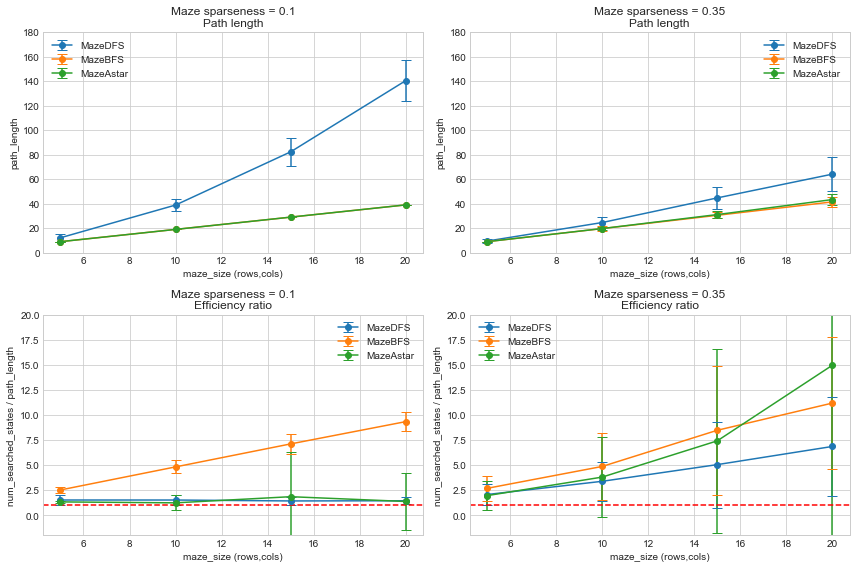

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statistics import stdev


algos = [MazeDFS, MazeBFS, MazeAstar]
maze_sizes = [5, 10, 15, 20]
n_iter = 100  # for calculating mean and SD

def plot_path_length():
    for algo in algos:
        path_lengths = []
        stds = []
        for m, x in enumerate(maze_sizes):
            path_lengths.append([])
            # Repeat for n_iter random mazes and take the mean and SD
            for _ in range(n_iter):
                solution = None
                searcher = algo()
                while not solution:
                    solution = searcher.run(Maze(x,x,sparseness))
                path_lengths[m].append(len(searcher.node_to_path(solution)))
            stds.append(stdev(path_lengths[m]))
            path_lengths[m] = sum(path_lengths[m]) / len(path_lengths[m])

        plt.errorbar(maze_sizes, path_lengths, yerr=stds, capsize=5, fmt='o-', label=algo.__name__)
        
def plot_ratio():
    for algo in algos:
        ratios = []
        stds = []
        for m, x in enumerate(maze_sizes):
            ratios.append([])
            # Repeat for n_iter random mazes and take the mean and SD
            for _ in range(n_iter):
                solution = None
                searcher = algo()
                while not solution:
                    solution = searcher.run(Maze(x,x,sparseness))
                path_length = len(searcher.node_to_path(solution))
                count_states = searcher.count_states
                ratios[m].append(count_states / path_length)
            stds.append(stdev(ratios[m]))
            ratios[m] = sum(ratios[m]) / len(ratios[m])

        plt.errorbar(maze_sizes, ratios, yerr=stds, capsize=5, fmt='o-', label=algo.__name__)
    

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(12,8))

# Plots for sparse mazes
sparseness = 0.1

ax1 = plt.subplot(221)
plot_path_length()    
ax1.set(xlabel='maze_size (rows,cols)', ylabel='path_length', ylim=[0, 180],
       title=f'Maze sparseness = {sparseness}\nPath length')
plt.legend();

ax2 = plt.subplot(223)
plot_ratio()
ax2.axhline(y=1, color='r', ls='--')
ax2.set(xlabel='maze_size (rows,cols)', ylabel='num_searched_states / path_length', ylim=[-2, 20],
       title=f'Maze sparseness = {sparseness}\nEfficiency ratio')
plt.legend();

# Plots for dense mazes
sparseness = 0.35

ax3 = plt.subplot(222)
plot_path_length()    
ax3.set(xlabel='maze_size (rows,cols)', ylabel='path_length', ylim=[0, 180],
       title=f'Maze sparseness = {sparseness}\nPath length')
plt.legend();

ax4 = plt.subplot(224)
plot_ratio()
ax4.axhline(y=1, color='r', ls='--')
ax4.set(xlabel='maze_size (rows,cols)', ylabel='num_searched_states / path_length', ylim=[-2, 20],
       title=f'Maze sparseness = {sparseness}\nEfficiency ratio')
plt.legend();

fig.tight_layout()


### 2.3 Missionaries and cannibals

The Missionaries and Cannibles problem is just like a maze, but the possible moves are constrained by social rules instead of spatial rules. :-)

So let's define another subclass of SearchProblem and find a solution using the same algorithms above.

In [104]:
class MCProblemFactory(object):
    def __new__(cls, MAX_NUM=3):
        # returns new instance of MCProblem with MAX_NUM missionaries
        # and cannibals (hyperparameter analog to maze size)
        if MAX_NUM < 1:
            raise ValueError('Cannot run the MC problem with <1 missionaries and cannibals!')
        MCState.MAX_NUM = MAX_NUM
        return MCState(missionaries=MAX_NUM, cannibals=MAX_NUM, boat=True)


class MCState(SearchProblem):
    MAX_NUM = 3
    
    def __init__(self, missionaries: int, cannibals: int, boat: bool):
        # initial values are m/c on the west bank
        self._wm = missionaries
        self._wc = cannibals
        self._em = self.MAX_NUM - missionaries
        self._ec = self.MAX_NUM - cannibals
        self._boat = boat  # true if boat is on west bank
        
    @property
    def wm(self):
        return self._wm
        
    @property
    def wc(self):
        return self._wc
        
    @property
    def em(self):
        return self._em
        
    @property
    def ec(self):
        return self._ec
        
    @property
    def boat(self):
        return self._boat
    
    def __str__(self):
        return ("{wm}M | {wb}{s}{eb} | {em}M\n"
               "{wc}C |  {s}  | {ec}C\n")\
                .format(wm=self.wm, em=self.em, wc=self.wc, ec=self.ec,
                       wb=('B' if self.boat else ' '), eb=(' ' if self.boat else 'B'),
                       s=' ' * 15)
    
    def __eq__(self, other):
        return self.__class__ == other.__class__ and\
                self.wm == other.wm and self.wc == other.wc and self.boat == other.boat
    
    def __hash__(self):
        # If no hash method, impossible to keep track of already
        # visited states (because we are using Set as backing store for 'explored').
        # The values used to compute the hash must be immutable throughout
        # the object's lifetime, so we created them as properties without setters.
        return hash((self.boat, self.wm, self.wc))
    
    
    def goal_test(self) -> bool:
        return self.is_legal and self.em == self.MAX_NUM and self.ec == self.MAX_NUM
    
    @property
    def is_legal(self) -> bool:
        # missionaries cannot be outnumbered by cannibals on either bank
        if self.wm < self.wc and self.wm > 0:
            return False
        if self.em < self.ec and self.em > 0:
            return False
        return True
    
    def successors(self):
        sucs = []
        if self.boat: # boat on west bank
            if self.wm > 1:
                sucs.append(MCState(self.wm - 2, self.wc, not self.boat))
            if self.wm > 0:
                sucs.append(MCState(self.wm - 1, self.wc, not self.boat))
            if self.wc > 1:
                sucs.append(MCState(self.wm, self.wc - 2, not self.boat))
            if self.wc > 0:
                sucs.append(MCState(self.wm, self.wc - 1, not self.boat))
            if (self.wc > 0) and (self.wm > 0):
                sucs.append(MCState(self.wm - 1, self.wc - 1, not self.boat))
        else: # boat on east bank
            if self.em > 1:
                sucs.append(MCState(self.wm + 2, self.wc, not self.boat))
            if self.em > 0:
                sucs.append(MCState(self.wm + 1, self.wc, not self.boat))
            if self.ec > 1:
                sucs.append(MCState(self.wm, self.wc + 2, not self.boat))
            if self.ec > 0:
                sucs.append(MCState(self.wm, self.wc + 1, not self.boat))
            if (self.ec > 0) and (self.em > 0):
                sucs.append(MCState(self.wm + 1, self.wc + 1, not self.boat))
        return [x for x in sucs if x.is_legal]
    

class MCBFS(MazeBFS):
    def __init__(self):
        super().__init__()
        
    def run(self, mcstate):
        return self._search(mcstate, MCState.goal_test, MCState.successors)
    
    
class MCDFS(MazeDFS):
    def __init__(self):
        super().__init__()
        
    def run(self, mcstate):
        return self._search(mcstate, MCState.goal_test, MCState.successors)
    
    
def display_solution(path):
    if len(path) == 0: # sanity check
        return
    old_state = path[0]
    print(old_state)
    for current_state in path[1:]:
        if current_state.boat:
            print("WEST <<== EAST: {} missionaries, {} cannibals\n"
                  .format(old_state.em - current_state.em, old_state.ec - current_state.ec))
        else:
            print("WEST ==>> EAST: {} missionaries, {} cannibals\n"
                  .format(old_state.wm - current_state.wm, old_state.wc - current_state.wc))
        print(current_state)
        old_state = current_state
    

# Solve Missionaries and cannibals problems using BFS defined
# generically and previously applied to the Maze problem
MAX_NUM = 2

start = MCProblemFactory(MAX_NUM)  # sets the number of M/Cs for all future MCState instances
bfs = MCBFS()
solution = bfs.run(start)
if solution is None:
    print("No solution found!")
else:
    path = bfs.node_to_path(solution)
    print(f'Path length: {len(path)}')
    print(f'Searched states: {bfs.count_states}\n')
    display_solution(path)
    


Path length: 6
Searched states: 10

2M | B                 | 0M
2C |                   | 0C

WEST ==>> EAST: 0 missionaries, 2 cannibals

2M |                 B | 0M
0C |                   | 2C

WEST <<== EAST: 0 missionaries, 1 cannibals

2M | B                 | 0M
1C |                   | 1C

WEST ==>> EAST: 2 missionaries, 0 cannibals

0M |                 B | 2M
1C |                   | 1C

WEST <<== EAST: 1 missionaries, 0 cannibals

1M | B                 | 1M
1C |                   | 1C

WEST ==>> EAST: 1 missionaries, 1 cannibals

0M |                 B | 2M
0C |                   | 2C

